# 04 - LTspice vs Dynamic Phasor Framework Comparison

This notebook compares **two LTspice simulations** (v1: 1 µs step, v2: 0.1 µs step) with the **Dynamic Phasor Framework** for the Rim et al. (2025) series RLC circuit.

## Methods Compared

1. **LTspice v1** (`rim2025/rim2025.raw`) — `.tran 0 0.5m 0 1u` → 1178 output points (adaptive compression)
2. **LTspice v2** (`rim2025_v2/rim2025-01u.raw`) — `.tran 0 0.5m 0 0.1u` → 5688 output points (10× denser)
3. **Framework Time-Domain** — classical ODE integration
4. **Framework Phasor-Domain (IDP)** — Instantaneous Dynamic Phasor

## LTspice Netlist (both versions)

```spice
V1 N001 N004 SINE(0 1 92.3k 0 0 0)
R1 N002 N001 3
L1 N002 N003 100.04µ Rser=1m
C1 N003 N004 30.07n
R2 N003 N004 2k
.tran 0 0.5m 0 {1u | 0.1u}   ← only this line differs
```

**Note**: `N004` is the circuit ground. Framework maps `N004 → 0`.

### Circuit Topology

```
       R1(3Ω)    L1(100.04µH)
 N001 ---/\/\--- N002 ---UUUU--- N003 ---+---+
  +                                         |   |
 V1 (1V, 92.3kHz)                    C1(30.07n) R2(2kΩ)
  -                                         |   |
 N004(GND) ----------------------------------+---+
```

### LTspice Files

- `framework/dynamic_phasor_LTspice/ltspice_simulations/rim2025/` (v1, 1 µs step)
- `framework/dynamic_phasor_LTspice/ltspice_simulations/rim2025_v2/` (v2, 0.1 µs step)


In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Add framework to path
sys.path.insert(0, '../dynamic_phasor_LTspice')

from core.netlist_parser import parse_ltspice_netlist
from core.mna_circuit import NetlistCircuit
from core.ltspice_raw_reader import read_raw

plt.rcParams.update({
    'figure.figsize': (14, 5),
    'font.size': 11,
    'lines.linewidth': 1.5,
    'axes.grid': True,
    'grid.alpha': 0.3,
})

print('Imports OK')

Imports OK


## 1. Framework Simulation

Parse the LTspice netlist (with `N004 → 0` mapping) and run both time-domain and phasor-domain simulations.

In [2]:
# Original LTspice netlist with N004 mapped to ground (0)
# L1 Rser=1m is parsed but negligible (1mΩ vs Rs=3Ω)
netlist_text = """
* Rim et al. (2025) RLC - exact LTspice circuit (N004→0)
V1 N001 0 SINE(0 1 92.3k 0 0 0)
R1 N002 N001 3
L1 N002 N003 100.04u Rser=1m
C1 N003 0 30.07n
R2 N003 0 2k
.tran 0 0.5m 0 1u
.end
"""

netlist = parse_ltspice_netlist(netlist_text)
circuit = NetlistCircuit(netlist)
print(circuit.info())

# Eigenvalue check
eigvals = np.linalg.eigvals(circuit._M_reduced)
print(f'Eigenvalues: {eigvals}')
print(f'Stable: {np.all(eigvals.real < 0)}')

Netlist: Rim et al. (2025) RLC - exact LTspice circuit (N004→0)
  Nodes: 3 (excl. ground)
  Elements: 5
    Resistors: 2
    Inductors: 1
    Capacitors: 1
    V-sources: 1
  Analysis: .tran {'t_step': 0.0, 't_stop': 0.0005, 't_start': 0.0, 't_maxstep': 1e-06}

MNA system size: 5
  Node voltages: 3
  V-source branches: 1
  Inductor branches: 1
  State labels: ['V(N001)', 'V(N002)', 'V(N003)', 'I(V1)', 'I(L1)']

Estimated resonant freq: 91.76 kHz
Estimated Q factor: 19.23
Eigenvalues: [-23307.93655268+576523.87034306j -23307.93655268-576523.87034306j]
Stable: True


In [3]:
# ── Time-Domain Simulation ──
td = circuit.solve_time_domain()
t_fw = td['t']

print(f'Time-domain: {len(t_fw)} points, '
      f'[{t_fw[0]*1e3:.3f}, {t_fw[-1]*1e3:.3f}] ms')
print(f'  V(N003) range: [{td["V(N003)"].min():.4f}, {td["V(N003)"].max():.4f}] V')
print(f'  I(L1)   range: [{td["I(L1)"].min():.6f}, {td["I(L1)"].max():.6f}] A')

# ── Phasor-Domain Simulation (IDP) ──
omega_s = 2 * np.pi * 92.3e3
circuit.configure_phasor(omega_s=omega_s)
pd = circuit.solve_phasor_domain()
t_pd = pd['t']

print(f'\nPhasor-domain: {len(t_pd)} points, '
      f'[{t_pd[0]*1e3:.3f}, {t_pd[-1]*1e3:.3f}] ms')
print(f'  V(N003) envelope (SS): {pd["envelopes"]["V(N003)"][-1]:.4f} V')
print(f'  I(L1)   envelope (SS): {pd["envelopes"]["I(L1)"][-1]:.6f} A')
print(f'  Speedup potential: ~{len(t_fw)/len(t_pd):.1f}x')

Time-domain: 9230 points, [0.000, 0.500] ms
  V(N003) range: [-12.2000, 12.2000] V
  I(L1)   range: [-0.212840, 0.212840] A



Phasor-domain: 2000 points, [0.000, 0.500] ms
  V(N003) envelope (SS): 12.2000 V
  I(L1)   envelope (SS): 0.212840 A
  Speedup potential: ~4.6x


## 2. Load LTspice Results

Both simulation runs are loaded from committed `.raw` files.

| Version | File | Max step | Points |
|---------|------|----------|--------|
| v1 | `rim2025/rim2025.raw` | 1 µs | ~1178 (adaptive) |
| v2 | `rim2025_v2/rim2025-01u.raw` | 0.1 µs | ~5688 (adaptive) |


In [4]:
# ══════════════════════════════════════════════════════════════
# LTspice .raw files (v1: 1µs step, v2: 0.1µs step)
# ══════════════════════════════════════════════════════════════
RAW_V1 = '../dynamic_phasor_LTspice/ltspice_simulations/rim2025/rim2025.raw'
RAW_V2 = '../dynamic_phasor_LTspice/ltspice_simulations/rim2025_v2/rim2025-01u.raw'

def load_ltspice(path, label):
    if not os.path.exists(path):
        print(f'WARNING [{label}]: not found at {os.path.abspath(path)}')
        return None
    data = read_raw(path)
    print(f'[{label}] {data.summary()}')
    print()
    return data

ltspice_v1 = load_ltspice(RAW_V1, 'v1 (1µs)')
ltspice_v2 = load_ltspice(RAW_V2, 'v2 (0.1µs)')


[v1 (1µs)] LTspice Raw Data: C:\Users\damia\OneDrive\바탕 화면\rim2025.net
  Analysis: Transient Analysis
  Points: 1178
  Variables (11):
    time (time): [0, 0.0005]
    V(n001) (voltage): [-11.7115, 11.7205]
    V(n002) (voltage): [-11.7054, 11.6988]
    V(n003) (voltage): [-0.0016649, 0.00300328]
    V(n004) (voltage): [-11.311, 11.312]
    I(C1) (device_current): [-0.199417, 0.199658]
    I(L1) (device_current): [-0.19955, 0.199633]
    I(R1) (device_current): [-0.199633, 0.19955]
    I(R2) (device_current): [-0.00565592, 0.00565538]
    I(V1) (device_current): [-0.199633, 0.19955]
    L1:flux (voltage): [-1.9963e-05, 1.99713e-05]

[v2 (0.1µs)] LTspice Raw Data: C:\Users\damia\OneDrive\바탕 화면\rim2025_v2\rim2025-01u.net
  Analysis: Transient Analysis
  Points: 5688
  Variables (11):
    time (time): [0, 0.0005]
    V(n001) (voltage): [-12.3489, 12.3484]
    V(n002) (voltage): [-12.3321, 12.3323]
    V(n003) (voltage): [-0.013004, 0.0122557]
    V(n004) (voltage): [-12.1766, 12.1783]
   

## 3. Signal Extraction & Alignment

**Important: LTspice ground reference**

Neither LTspice netlist has an explicit GND symbol (node 0). LTspice measures all node
voltages w.r.t. an internal floating reference (effectively N003, the output node).

Correct comparison requires **differential voltages** from LTspice:
- Output voltage: `V_lt = V(n003) - V(n004)`
- Source check: `V(n001) - V(n004)` should be ~1 V amplitude ✓

The framework measures all voltages w.r.t. its ground (= N004 of the original netlist), so
framework `V(N003)` matches `V(n003) - V(n004)` from LTspice directly.


In [5]:
# Extract framework signals
V_fw = td['V(N003)']
I_fw = td['I(L1)']

# Extract phasor-domain signals
V_pd = pd['V(N003)']
I_pd = pd['I(L1)']
V_env = pd['envelopes']['V(N003)']
I_env = pd['envelopes']['I(L1)']

def extract_ltspice_signals(data, label):
    """Extract differential voltages and current from an LTspice raw dataset."""
    if data is None:
        return None
    t = np.real(data.time)
    V3 = data.voltage('N003')
    V4 = data.voltage('N004')
    V1n = data.voltage('N001')
    IL = data.current('L1')
    if V3 is None or V4 is None or IL is None:
        print(f'[{label}] Missing signals.')
        return None
    V_out = V3 - V4
    V_src = V1n - V4 if V1n is not None else None
    src_peak = np.max(np.abs(V_src)) if V_src is not None else float('nan')
    print(f'[{label}] {len(t)} pts | V_src peak={src_peak:.4f} V | '
          f'V_out=[{V_out.min():.4f},{V_out.max():.4f}] V | '
          f'I_L1=[{IL.min():.6f},{IL.max():.6f}] A')
    return dict(t=t, V=V_out, I=IL)

sig_v1 = extract_ltspice_signals(ltspice_v1, 'v1')
sig_v2 = extract_ltspice_signals(ltspice_v2, 'v2')

# Build common time base spanning all sources
t_min = t_fw[0]
t_max = t_fw[-1]
if sig_v1: t_min = max(t_min, sig_v1['t'][0]); t_max = min(t_max, sig_v1['t'][-1])
if sig_v2: t_min = max(t_min, sig_v2['t'][0]); t_max = min(t_max, sig_v2['t'][-1])
t_common = np.linspace(t_min, t_max, 10000)

def interp_c(t_src, y_src):
    return interp1d(t_src, y_src, kind='cubic', fill_value='extrapolate')(t_common)

V_fw_c = interp_c(t_fw, V_fw)
I_fw_c = interp_c(t_fw, I_fw)
V_pd_c = interp_c(t_pd, V_pd)
I_pd_c = interp_c(t_pd, I_pd)

if sig_v1:
    V_v1_c = interp_c(sig_v1['t'], sig_v1['V'])
    I_v1_c = interp_c(sig_v1['t'], sig_v1['I'])
    t_lt   = sig_v1['t']   # for legacy references in downstream cells
    V_lt   = sig_v1['V']
    I_lt   = sig_v1['I']

if sig_v2:
    V_v2_c = interp_c(sig_v2['t'], sig_v2['V'])
    I_v2_c = interp_c(sig_v2['t'], sig_v2['I'])

print(f'\nCommon time base: {len(t_common)} points, [{t_common[0]*1e3:.3f}, {t_common[-1]*1e3:.3f}] ms')


[v1] 1178 pts | V_src peak=1.0000 V | V_out=[-11.3118,11.3108] V | I_L1=[-0.199550,0.199633] A
[v2] 5688 pts | V_src peak=1.0000 V | V_out=[-12.1771,12.1765] V | I_L1=[-0.212490,0.212498] A

Common time base: 10000 points, [0.000, 0.500] ms


## 4. Waveform Comparison

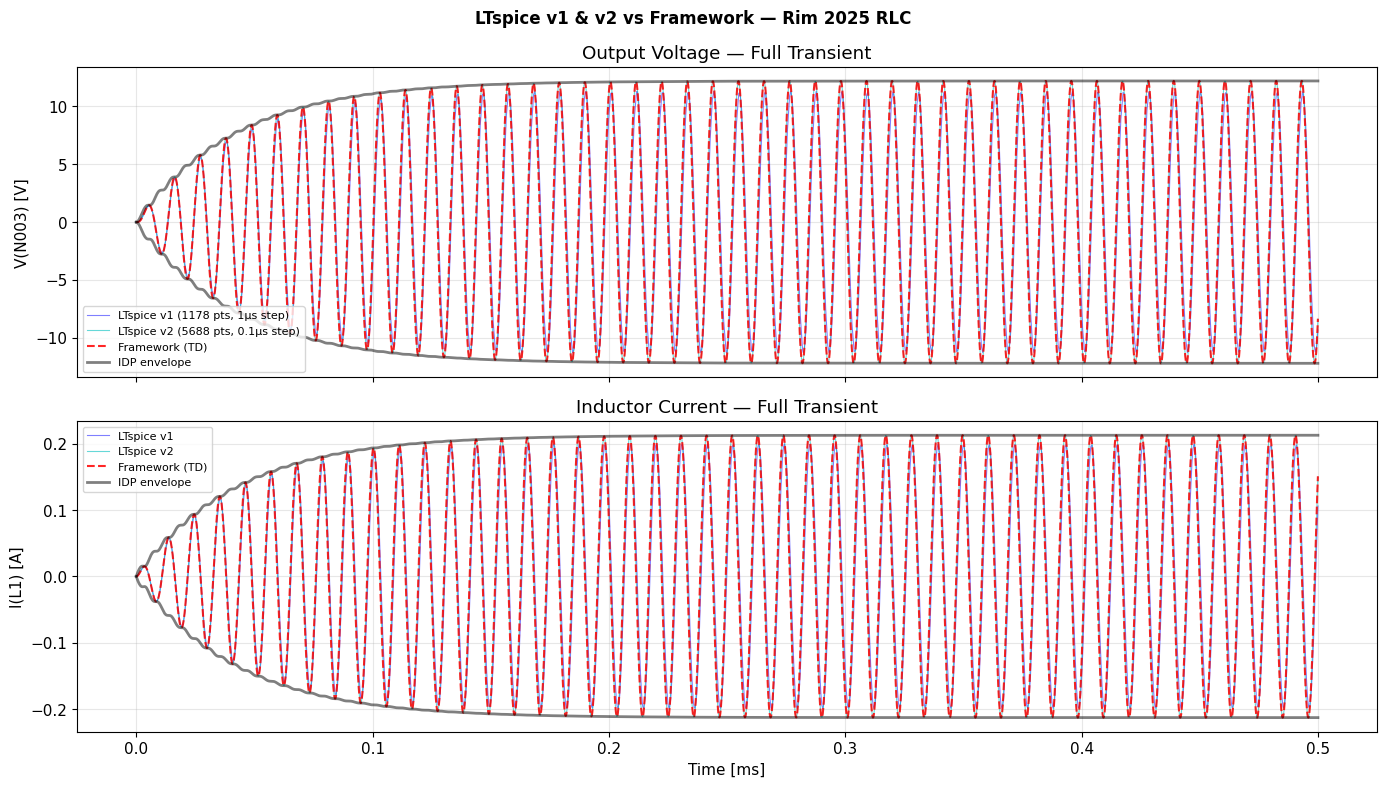

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

t_ms = t_common * 1e3

# ── Voltage ──
ax = axes[0]
if sig_v1:
    ax.plot(sig_v1['t']*1e3, sig_v1['V'], 'b-',  lw=0.8, alpha=0.5, label=f'LTspice v1 ({len(sig_v1["t"])} pts, 1µs step)')
if sig_v2:
    ax.plot(sig_v2['t']*1e3, sig_v2['V'], 'c-',  lw=0.8, alpha=0.6, label=f'LTspice v2 ({len(sig_v2["t"])} pts, 0.1µs step)')
ax.plot(t_fw*1e3, V_fw, 'r--', lw=1.5, alpha=0.85, label='Framework (TD)')
ax.plot(t_pd*1e3, V_env,  'k-',  lw=2.0, alpha=0.5, label='IDP envelope')
ax.plot(t_pd*1e3, -V_env, 'k-',  lw=2.0, alpha=0.5)
ax.set_ylabel('V(N003) [V]')
ax.set_title('Output Voltage — Full Transient')
ax.legend(fontsize=8); ax.grid(alpha=0.3)

# ── Current ──
ax = axes[1]
if sig_v1:
    ax.plot(sig_v1['t']*1e3, sig_v1['I'], 'b-',  lw=0.8, alpha=0.5, label='LTspice v1')
if sig_v2:
    ax.plot(sig_v2['t']*1e3, sig_v2['I'], 'c-',  lw=0.8, alpha=0.6, label='LTspice v2')
ax.plot(t_fw*1e3, I_fw, 'r--', lw=1.5, alpha=0.85, label='Framework (TD)')
ax.plot(t_pd*1e3, I_env,  'k-',  lw=2.0, alpha=0.5, label='IDP envelope')
ax.plot(t_pd*1e3, -I_env, 'k-',  lw=2.0, alpha=0.5)
ax.set_xlabel('Time [ms]'); ax.set_ylabel('I(L1) [A]')
ax.set_title('Inductor Current — Full Transient')
ax.legend(fontsize=8); ax.grid(alpha=0.3)

fig.suptitle('LTspice v1 & v2 vs Framework — Rim 2025 RLC', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


## 5. Transient Detail (First 100 µs)

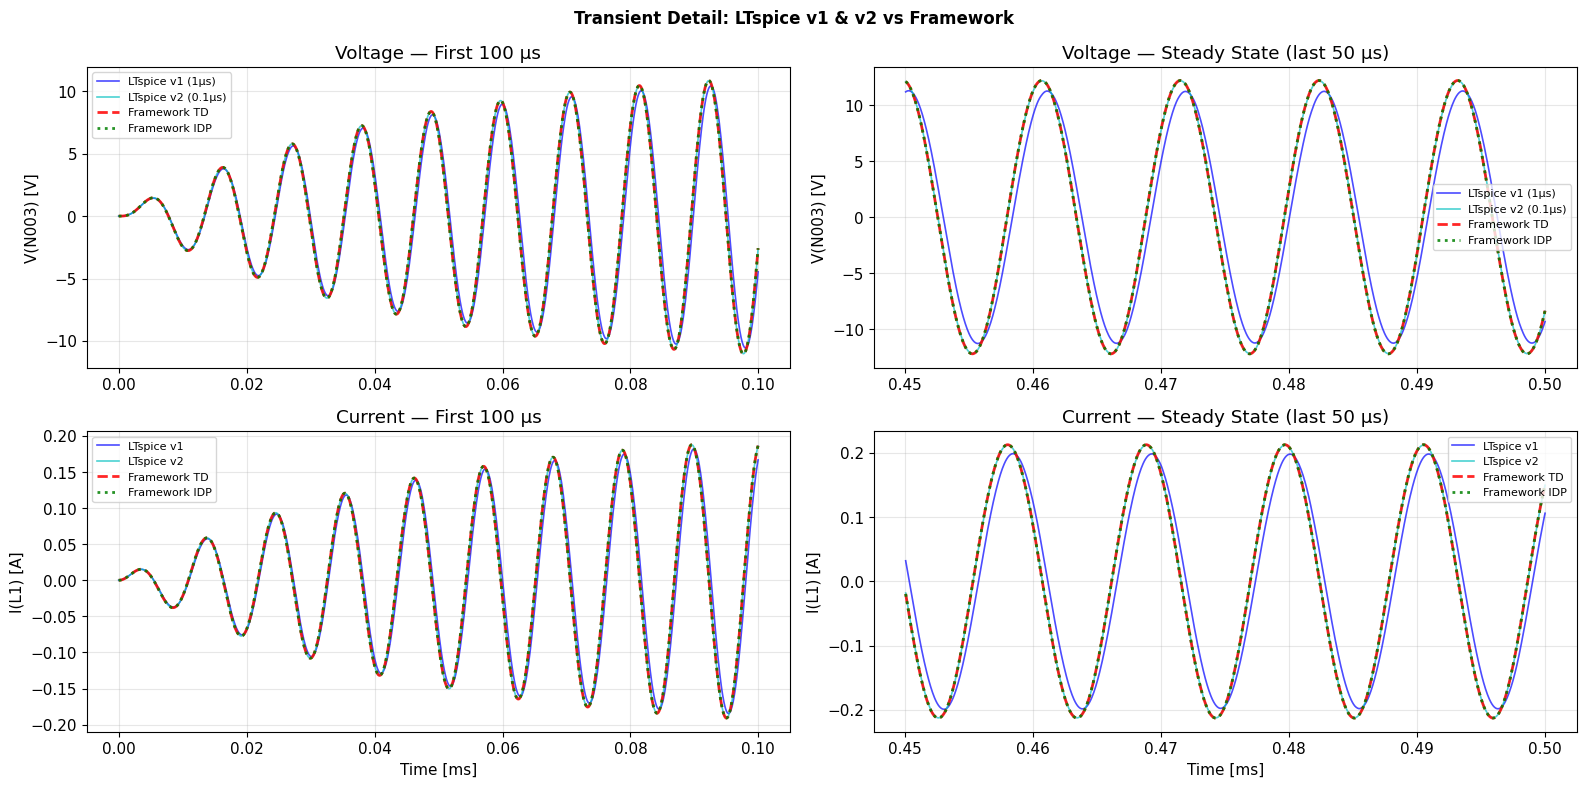

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

t_zoom_ms = 0.1  # first 100 µs
mask_zoom = t_common * 1e3 <= t_zoom_ms

# ── Steady-state zoom ──
ss_start_ms = 0.45
mask_ss = t_common * 1e3 >= ss_start_ms

for col, (mask, title_sfx) in enumerate([(mask_zoom, f'First {t_zoom_ms*1e3:.0f} µs'), (mask_ss, 'Steady State (last 50 µs)')]):
    t_ms_m = t_common[mask] * 1e3

    # Voltage
    ax = axes[0, col]
    if sig_v1: ax.plot(t_ms_m, V_v1_c[mask], 'b-',  lw=1.2, alpha=0.7, label='LTspice v1 (1µs)')
    if sig_v2: ax.plot(t_ms_m, V_v2_c[mask], 'c-',  lw=1.2, alpha=0.7, label='LTspice v2 (0.1µs)')
    ax.plot(t_ms_m, V_fw_c[mask], 'r--', lw=2.0, alpha=0.85, label='Framework TD')
    ax.plot(t_ms_m, V_pd_c[mask], 'g:',  lw=2.0, alpha=0.85, label='Framework IDP')
    ax.set_ylabel('V(N003) [V]'); ax.set_title(f'Voltage — {title_sfx}')
    ax.legend(fontsize=8); ax.grid(alpha=0.3)

    # Current
    ax = axes[1, col]
    if sig_v1: ax.plot(t_ms_m, I_v1_c[mask], 'b-',  lw=1.2, alpha=0.7, label='LTspice v1')
    if sig_v2: ax.plot(t_ms_m, I_v2_c[mask], 'c-',  lw=1.2, alpha=0.7, label='LTspice v2')
    ax.plot(t_ms_m, I_fw_c[mask], 'r--', lw=2.0, alpha=0.85, label='Framework TD')
    ax.plot(t_ms_m, I_pd_c[mask], 'g:',  lw=2.0, alpha=0.85, label='Framework IDP')
    ax.set_xlabel('Time [ms]'); ax.set_ylabel('I(L1) [A]')
    ax.set_title(f'Current — {title_sfx}')
    ax.legend(fontsize=8); ax.grid(alpha=0.3)

fig.suptitle('Transient Detail: LTspice v1 & v2 vs Framework', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


## 6. Error Metrics

In [8]:
def nrmse(ref, test):
    """Normalized RMSE as percentage."""
    rmse = np.sqrt(np.mean((ref - test)**2))
    rng = np.ptp(ref)
    return (rmse / rng * 100) if rng > 0 else 0.0

def peak_err(ref, test, frac=0.8):
    """Steady-state peak error as percentage."""
    s = int(frac * len(ref))
    pk_ref = np.max(np.abs(ref[s:]))
    pk_tst = np.max(np.abs(test[s:]))
    return 100 * abs(pk_ref - pk_tst) / pk_ref if pk_ref > 0 else 0.0

def corr(a, b):
    return np.corrcoef(a, b)[0, 1] if np.std(a) > 0 and np.std(b) > 0 else 1.0

ss = int(0.8 * len(t_common))

print('='*70)
print('ERROR METRICS')
print('='*70)

# ── TD vs IDP (internal consistency) ──
print('\n--- Framework: Time-Domain vs Phasor-Domain (IDP) ---')
print(f'  V(N003) NRMSE (full/SS): {nrmse(V_fw_c, V_pd_c):.4f}% / {nrmse(V_fw_c[ss:], V_pd_c[ss:]):.4f}%')
print(f'  I(L1)   NRMSE (full/SS): {nrmse(I_fw_c, I_pd_c):.4f}% / {nrmse(I_fw_c[ss:], I_pd_c[ss:]):.4f}%')

def print_lt_vs_fw(label, V_lt_c, I_lt_c):
    print(f'\n--- {label} ---')
    nV_full = nrmse(V_lt_c, V_fw_c);  nV_ss = nrmse(V_lt_c[ss:], V_fw_c[ss:])
    nI_full = nrmse(I_lt_c, I_fw_c);  nI_ss = nrmse(I_lt_c[ss:], I_fw_c[ss:])
    rV = corr(V_lt_c[ss:], V_fw_c[ss:]);  rI = corr(I_lt_c[ss:], I_fw_c[ss:])
    pV = peak_err(V_lt_c, V_fw_c);        pI = peak_err(I_lt_c, I_fw_c)
    print(f'  V(N003): NRMSE full={nV_full:.3f}%  SS={nV_ss:.3f}%  corr={rV:.5f}  peak_err={pV:.3f}%')
    print(f'  I(L1):   NRMSE full={nI_full:.3f}%  SS={nI_ss:.3f}%  corr={rI:.5f}  peak_err={pI:.3f}%')

if sig_v1: print_lt_vs_fw('LTspice v1 (1µs step) vs Framework TD',  V_v1_c, I_v1_c)
if sig_v2: print_lt_vs_fw('LTspice v2 (0.1µs step) vs Framework TD', V_v2_c, I_v2_c)
if sig_v1: print_lt_vs_fw('LTspice v1 vs Framework IDP',  V_v1_c, I_v1_c)
if sig_v2: print_lt_vs_fw('LTspice v2 vs Framework IDP', V_v2_c, I_v2_c)


ERROR METRICS

--- Framework: Time-Domain vs Phasor-Domain (IDP) ---
  V(N003) NRMSE (full/SS): 0.0000% / 0.0000%
  I(L1)   NRMSE (full/SS): 0.0000% / 0.0000%

--- LTspice v1 (1µs step) vs Framework TD ---
  V(N003): NRMSE full=8.216%  SS=9.254%  corr=0.97179  peak_err=7.979%
  I(L1):   NRMSE full=8.152%  SS=9.261%  corr=0.96960  peak_err=6.699%

--- LTspice v2 (0.1µs step) vs Framework TD ---
  V(N003): NRMSE full=0.208%  SS=0.235%  corr=0.99998  peak_err=0.185%
  I(L1):   NRMSE full=0.206%  SS=0.237%  corr=0.99998  peak_err=0.160%

--- LTspice v1 vs Framework IDP ---
  V(N003): NRMSE full=8.216%  SS=9.254%  corr=0.97179  peak_err=7.979%
  I(L1):   NRMSE full=8.152%  SS=9.261%  corr=0.96960  peak_err=6.699%

--- LTspice v2 vs Framework IDP ---
  V(N003): NRMSE full=0.208%  SS=0.235%  corr=0.99998  peak_err=0.185%
  I(L1):   NRMSE full=0.206%  SS=0.237%  corr=0.99998  peak_err=0.160%


## 7. Error Waveforms

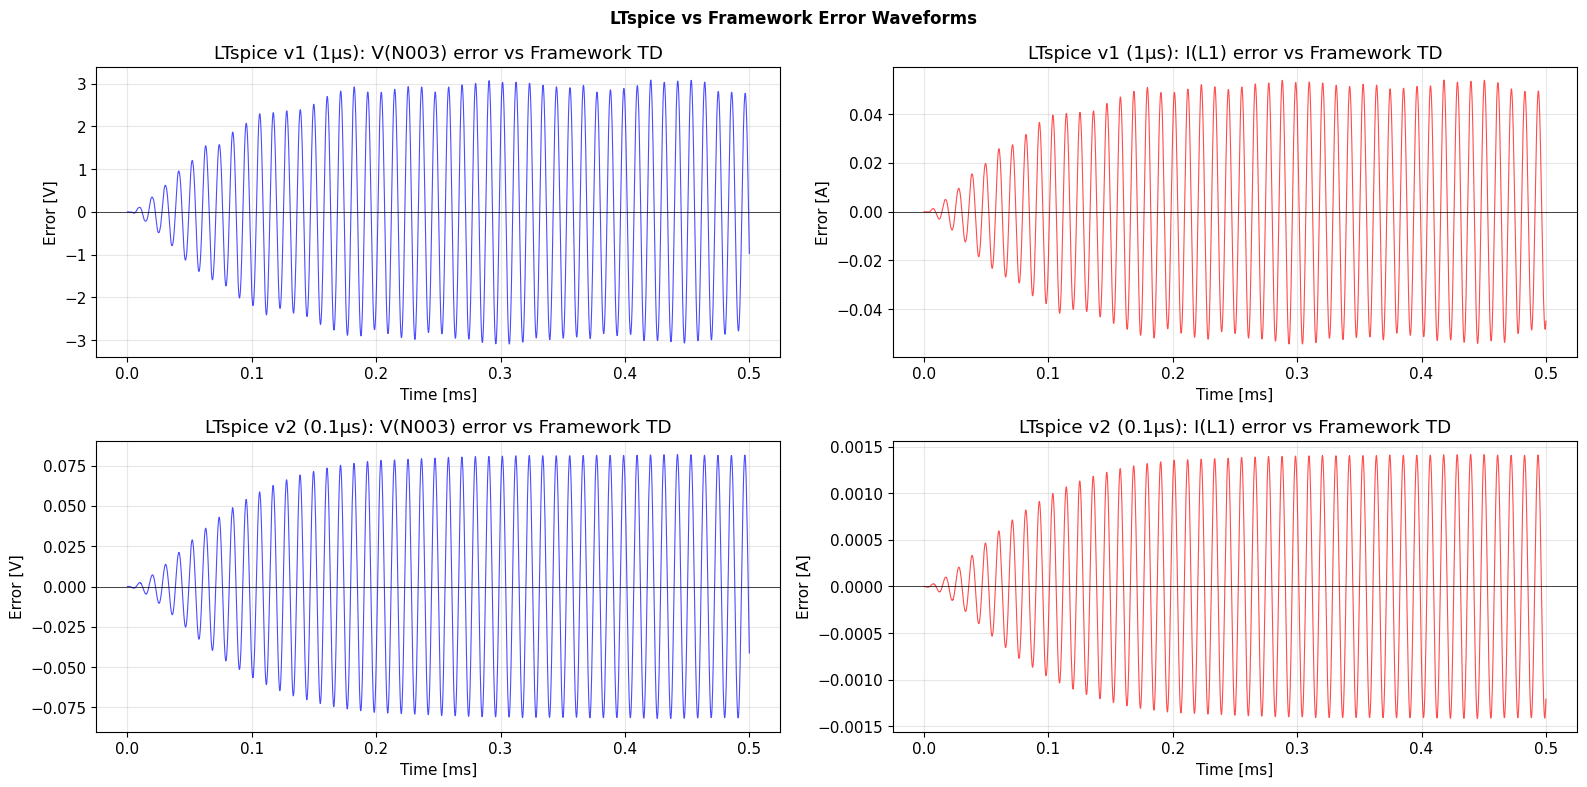

In [9]:
if sig_v1 or sig_v2:
    n_rows = sum([bool(sig_v1), bool(sig_v2)])
    fig, axes = plt.subplots(n_rows, 2, figsize=(16, 4 * n_rows))
    if n_rows == 1:
        axes = axes[np.newaxis, :]

    t_ms = t_common * 1e3
    row = 0
    for label, V_lt_c, I_lt_c in [
        ('LTspice v1 (1µs)', V_v1_c if sig_v1 else None, I_v1_c if sig_v1 else None),
        ('LTspice v2 (0.1µs)', V_v2_c if sig_v2 else None, I_v2_c if sig_v2 else None),
    ]:
        if V_lt_c is None:
            continue
        err_V = V_lt_c - V_fw_c
        err_I = I_lt_c - I_fw_c

        ax = axes[row, 0]
        ax.plot(t_ms, err_V, 'b-', lw=0.8, alpha=0.7)
        ax.axhline(0, color='k', lw=0.5)
        ax.set_title(f'{label}: V(N003) error vs Framework TD')
        ax.set_xlabel('Time [ms]'); ax.set_ylabel('Error [V]'); ax.grid(alpha=0.3)

        ax = axes[row, 1]
        ax.plot(t_ms, err_I, 'r-', lw=0.8, alpha=0.7)
        ax.axhline(0, color='k', lw=0.5)
        ax.set_title(f'{label}: I(L1) error vs Framework TD')
        ax.set_xlabel('Time [ms]'); ax.set_ylabel('Error [A]'); ax.grid(alpha=0.3)
        row += 1

    fig.suptitle('LTspice vs Framework Error Waveforms', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


## 8. Envelope Comparison

Compare the phasor envelope with the Hilbert-transform envelope extracted from the time-domain waveform.

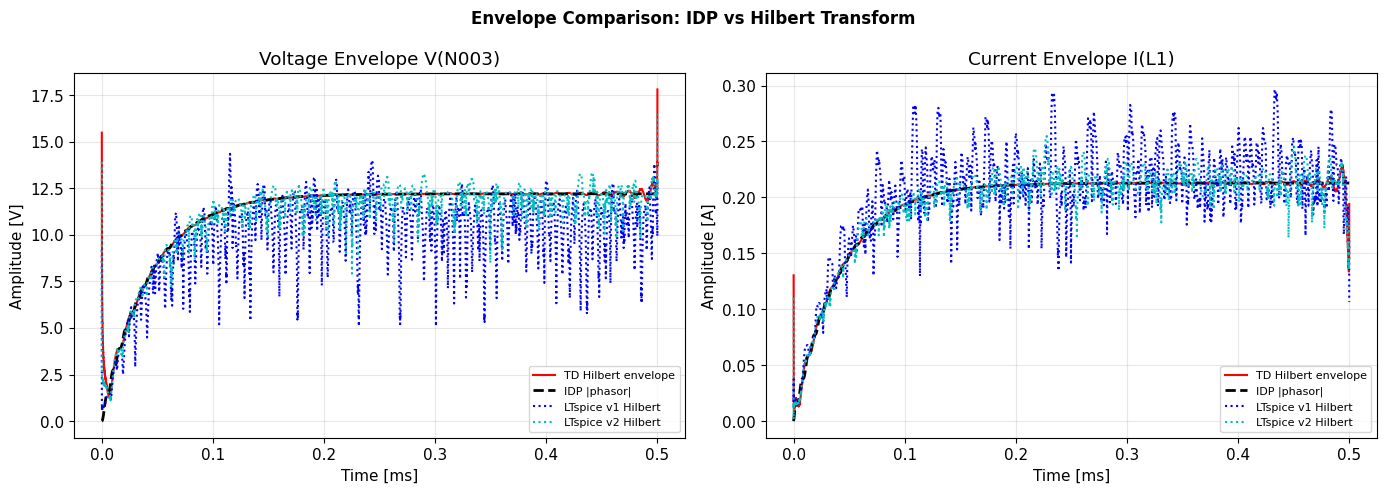

In [10]:
from scipy.signal import hilbert

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── Voltage Envelope ──
ax = axes[0]
ax.plot(t_fw*1e3, np.abs(hilbert(V_fw)), 'r-',  lw=1.5, label='TD Hilbert envelope')
ax.plot(t_pd*1e3, V_env,                  'k--', lw=2.0, label='IDP |phasor|')
if sig_v1:
    ax.plot(sig_v1['t']*1e3, np.abs(hilbert(sig_v1['V'])), 'b:', lw=1.5, label='LTspice v1 Hilbert')
if sig_v2:
    ax.plot(sig_v2['t']*1e3, np.abs(hilbert(sig_v2['V'])), 'c:', lw=1.5, label='LTspice v2 Hilbert')
ax.set_xlabel('Time [ms]'); ax.set_ylabel('Amplitude [V]')
ax.set_title('Voltage Envelope V(N003)'); ax.legend(fontsize=8); ax.grid(alpha=0.3)

# ── Current Envelope ──
ax = axes[1]
ax.plot(t_fw*1e3, np.abs(hilbert(I_fw)), 'r-',  lw=1.5, label='TD Hilbert envelope')
ax.plot(t_pd*1e3, I_env,                  'k--', lw=2.0, label='IDP |phasor|')
if sig_v1:
    ax.plot(sig_v1['t']*1e3, np.abs(hilbert(sig_v1['I'])), 'b:', lw=1.5, label='LTspice v1 Hilbert')
if sig_v2:
    ax.plot(sig_v2['t']*1e3, np.abs(hilbert(sig_v2['I'])), 'c:', lw=1.5, label='LTspice v2 Hilbert')
ax.set_xlabel('Time [ms]'); ax.set_ylabel('Amplitude [A]')
ax.set_title('Current Envelope I(L1)'); ax.legend(fontsize=8); ax.grid(alpha=0.3)

fig.suptitle('Envelope Comparison: IDP vs Hilbert Transform', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


## 9. Summary

In [11]:
print('='*70)
print('COMPARISON SUMMARY')
print('='*70)

# Circuit info
L = 100.04e-6; C = 30.07e-9; Rs = 3.0; Ro = 2000.0
f_r = 1/(2*np.pi*np.sqrt(L*C))
Q = np.sqrt(L/C) / Rs

print(f'\nCircuit: Rim et al. (2025) Series RLC')
print(f'  L={L*1e6:.2f}uH, C={C*1e9:.2f}nF, Rs={Rs}ohm, Ro={Ro/1e3:.0f}kohm')
print(f'  f_r={f_r/1e3:.2f} kHz, Q={Q:.1f}')
print(f'  Source: 1V @ 92.3 kHz')

# Simulation stats
print(f'\nData points:')
print(f'  Framework TD:    {len(t_fw):>6d} pts')
print(f'  Framework IDP:   {len(t_pd):>6d} pts  ({len(t_fw)/len(t_pd):.1f}x fewer than TD)')
if sig_v1: print(f'  LTspice v1 (1µs): {len(sig_v1["t"]):>5d} pts  (adaptive compression)')
if sig_v2: print(f'  LTspice v2 (0.1µs): {len(sig_v2["t"]):>4d} pts  (adaptive compression)')

# Steady-state peaks
ss_fw = int(0.8 * len(t_fw))
Vpk_fw = np.max(np.abs(V_fw[ss_fw:]))
Ipk_fw = np.max(np.abs(I_fw[ss_fw:]))
Vpk_pd = pd['envelopes']['V(N003)'][-1]
Ipk_pd = pd['envelopes']['I(L1)'][-1]
omega = 2*np.pi*92.3e3
Z_CR = Ro/(1+1j*omega*Ro*C)
Z_tot = Rs + 1j*omega*L + Z_CR
V_ana = abs(1.0/Z_tot) * abs(Z_CR)
I_ana = abs(1.0/Z_tot)

print(f'\nSteady-State Peak Values:')
print(f'  {"Method":<24s} {"V(N003) [V]":>12s} {"I(L1) [A]":>12s}')
print(f'  {"-"*24} {"-"*12} {"-"*12}')
print(f'  {"Analytical":<24s} {V_ana:>12.4f} {I_ana:>12.6f}')
if sig_v1:
    ss_v1 = int(0.8*len(sig_v1['t']))
    print(f'  {"LTspice v1 (1µs)":<24s} {np.max(np.abs(sig_v1["V"][ss_v1:])):>12.4f} {np.max(np.abs(sig_v1["I"][ss_v1:])):>12.6f}')
if sig_v2:
    ss_v2 = int(0.8*len(sig_v2['t']))
    print(f'  {"LTspice v2 (0.1µs)":<24s} {np.max(np.abs(sig_v2["V"][ss_v2:])):>12.4f} {np.max(np.abs(sig_v2["I"][ss_v2:])):>12.6f}')
print(f'  {"Framework (TD)":<24s} {Vpk_fw:>12.4f} {Ipk_fw:>12.6f}')
print(f'  {"Framework (IDP)":<24s} {Vpk_pd:>12.4f} {Ipk_pd:>12.6f}')

# Validation table
td_idp_V = nrmse(V_fw_c[ss:], V_pd_c[ss:])
td_idp_I = nrmse(I_fw_c[ss:], I_pd_c[ss:])

print(f'\nValidation (NRMSE steady-state):')
print(f'  {"Comparison":<30s} {"V NRMSE":>10s} {"I NRMSE":>10s} {"Status":>8s}')
print(f'  {"-"*30} {"-"*10} {"-"*10} {"-"*8}')

def status(V, I, thr=1.0): return 'PASS' if V < thr and I < thr else 'FAIL'

print(f'  {"TD vs IDP":<30s} {td_idp_V:>9.4f}% {td_idp_I:>9.4f}% {status(td_idp_V, td_idp_I):>8s}')
if sig_v1:
    v1_td_V = nrmse(V_v1_c[ss:], V_fw_c[ss:]); v1_td_I = nrmse(I_v1_c[ss:], I_fw_c[ss:])
    print(f'  {"LTspice v1 vs TD":<30s} {v1_td_V:>9.4f}% {v1_td_I:>9.4f}% {status(v1_td_V, v1_td_I):>8s}')
if sig_v2:
    v2_td_V = nrmse(V_v2_c[ss:], V_fw_c[ss:]); v2_td_I = nrmse(I_v2_c[ss:], I_fw_c[ss:])
    print(f'  {"LTspice v2 vs TD":<30s} {v2_td_V:>9.4f}% {v2_td_I:>9.4f}% {status(v2_td_V, v2_td_I):>8s}')

if sig_v1 and sig_v2:
    print(f'\nConclusion: v2 (0.1µs step) gives {v1_td_V/v2_td_V:.1f}x lower NRMSE than v1 (1µs step),')
    print(f'  confirming the 9% NRMSE of v1 was due to sparse LTspice adaptive output compression,')
    print(f'  not a framework error.')

print(f'\n{"="*70}')
print('DONE')
print('='*70)


COMPARISON SUMMARY

Circuit: Rim et al. (2025) Series RLC
  L=100.04uH, C=30.07nF, Rs=3.0ohm, Ro=2kohm
  f_r=91.76 kHz, Q=19.2
  Source: 1V @ 92.3 kHz

Data points:
  Framework TD:      9230 pts
  Framework IDP:     2000 pts  (4.6x fewer than TD)
  LTspice v1 (1µs):  1178 pts  (adaptive compression)
  LTspice v2 (0.1µs): 5688 pts  (adaptive compression)

Steady-State Peak Values:
  Method                    V(N003) [V]    I(L1) [A]
  ------------------------ ------------ ------------
  Analytical                    12.2000     0.212840
  LTspice v1 (1µs)              11.2735     0.199027
  LTspice v2 (0.1µs)            12.1771     0.212498
  Framework (TD)                12.2000     0.212840
  Framework (IDP)               12.2000     0.212840

Validation (NRMSE steady-state):
  Comparison                        V NRMSE    I NRMSE   Status
  ------------------------------ ---------- ---------- --------
  TD vs IDP                         0.0000%    0.0000%     PASS
  LTspice v1 vs TD  